In [ ]:
ID = "YOUR ID HERE"
NAME = "YOUR NAME HERE"

# Assignment 2 Part 2: Starter Notebook
Welcome to NNFL Assignment 2: Part 2. Please read the instructions given below carefully before attempting the assignment.  
- Do NOT import any other modules or functions.
- Do NOT change the prototypes of any of the functions unless told to.
- Grading will be done based on the categorical accuracy of the built model on the test dataset.


**BEFORE STARTING OFF, MAKE SURE HARDWARE ACCELERATION IS TURNED ON.
In Google Colab, go to Runtime->Change Runtime Type->Select GPU in the Hardware Accelerator.**

## Data Preprocessing

We will be using the same data preprocessing we used in the Part 1 of the assignment, you may run all these cells and skip the the Next Section. We have made only one change: we split the train set into training and validation set since the test dataset is private for this assingment.

In [1]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!git clone https://github.com/BITS-NNFL/Coronavirus-Tweets-Dataset-P2.git
%cd ./Coronavirus-Tweets-Dataset-P2/

Cloning into 'Coronavirus-Tweets-Dataset-P2'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/Coronavirus-Tweets-Dataset-P2


## Data Processing
Let's first read the csv files for train and test into Pandas DataFrames. 
 - We will be using Pandas for this.
 - We will retrieve only the columns of **OriginalTweet and Sentiment** for the train dataset and only the **OriginalTweet** column for the test dataset while we read the csv into a pandas dataframe.
 - We will specify the encoding as **latin1** while we read the csv into a pandas dataframe.

In [3]:
def load_dataframe(filename, usecols):
    """
    Args:
        'filename': filename of csv to be loaded
    Returns:
        'df': Pandas DataFrame with appropriate csv loaded
    """
    df= pd.read_csv(filename, usecols=usecols,encoding='latin1')
    return df

In [4]:
train = load_dataframe('P2_Coronavirus_Tweets_Train.csv', usecols=["OriginalTweet", "Sentiment"])
test = load_dataframe('P2_Coronavirus_Tweets_Test.csv', usecols=["OriginalTweet"])

In [5]:
def sentiment_map(df):
    """
    Args:
        'df': Pandas DataFrame
    Returns:
        'df': Pandas DataFrame with Sentiment column with the new mapping as described
    """
    df['Sentiment'] = df['Sentiment'].map({'Extremely Positive':'Positive', 'Extremely Negative':'Negative', 'Negative':'Negative', 'Positive':'Positive', 'Neutral':'Neutral'})
    return df

In [6]:
train = sentiment_map(train)

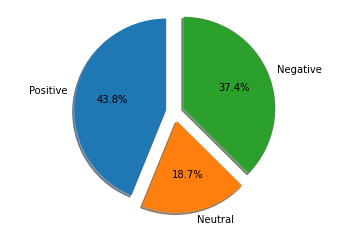

In [7]:
vals = [len(train[train['Sentiment']=='Positive']['Sentiment']), len(train[train['Sentiment']=='Neutral']['Sentiment']), len(train[train['Sentiment']=='Negative']['Sentiment'])]
idx = ['Positive', 'Neutral', 'Negative']
explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(vals, explode=explode, labels=idx, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

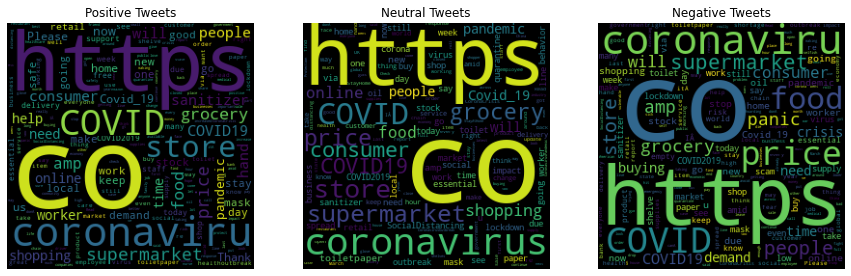

In [8]:
positive = " ".join(train[train['Sentiment'] == 'Positive']['OriginalTweet'].to_list())
neutral = " ".join(train[train['Sentiment'] == 'Neutral']['OriginalTweet'].to_list())
negative = " ".join(train[train['Sentiment'] == 'Negative']['OriginalTweet'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
pos_cloud = WordCloud(width=256, height=256, collocations=False).generate(positive)
neut_cloud = WordCloud(width=256, height=256, collocations=False).generate(neutral)
neg_cloud = WordCloud(width=256, height=256, collocations=False).generate(negative)
clouds = [pos_cloud, neut_cloud, neg_cloud]
titls = ["Positive Tweets", "Neutral Tweets", "Negative Tweets"]

for no, x in enumerate(clouds):
    ax[no].imshow(x)
    ax[no].axis('off')
    ax[no].set_title(titls[no])

In [9]:
def remove_urls(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': string with URLs removed (remove links starting with https:// and www.)
    """
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    text_processed = url_remove.sub(r'', text)
    return text_processed

In [10]:
def lower(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': lowercase converted string 
    """
    low_text= text.lower()
    return low_text

In [11]:
def remove_num(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with numbers removed
    """
    text_processed= re.sub(r'\d+', '', text)
    return text_processed

In [12]:
def remove_punc(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with punctuation removed using regex
    """
    text_processed = re.sub(r"[^\w\s\d]","", text)
    return text_processed

In [13]:
stops = stopwords.words("english")

In [14]:
def remove_stopwords(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with stopwords removed
    """    
    text = text.split()
    text_processed = " ".join([word for word in text if word not in stops])
    return text_processed

In [15]:
def remove_space(text):
    """
    Args:
        'text': string containing tweet 
    Returns:
        'text_processed': corresponding string with extra white space removed
    """ 
    text_processed = re.sub(r"\s+"," ",text).strip()
    return text_processed

In [16]:
def clean_text(data):
    """
    Args:
        'data': Pandas dataframe
    Returns:
        'data': cleaned dataframe with the prior functions (remove_urls(),lower(),remove_num(),remove_punc(),remove_stopwords(),remove_space()) applied to the OriginalTweet column
    """ 
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : remove_urls(x))
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : lower(x))
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : remove_num(x))
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : remove_punc(x))
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : remove_stopwords(x))
    data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : remove_space(x))
    return data

In [17]:
train_cleaned = clean_text(train)
test_cleaned = clean_text(test)

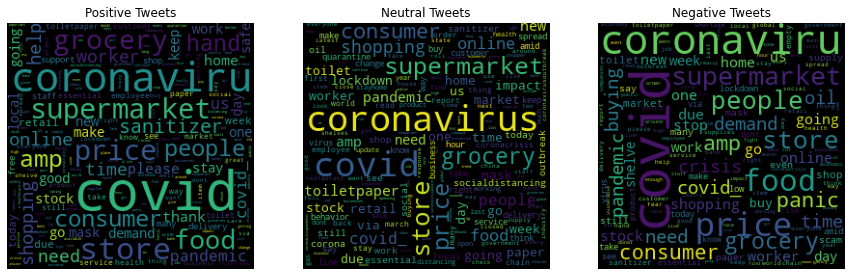

In [18]:
positive = " ".join(train[train['Sentiment'] == 'Positive']['OriginalTweet'].to_list())
neutral = " ".join(train[train['Sentiment'] == 'Neutral']['OriginalTweet'].to_list())
negative = " ".join(train[train['Sentiment'] == 'Negative']['OriginalTweet'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
pos_cloud = WordCloud(width=256, height=256, collocations=False).generate(positive)
neut_cloud = WordCloud(width=256, height=256, collocations=False).generate(neutral)
neg_cloud = WordCloud(width=256, height=256, collocations=False).generate(negative)
clouds = [pos_cloud, neut_cloud, neg_cloud]
titls = ["Positive Tweets", "Neutral Tweets", "Negative Tweets"]

for no, x in enumerate(clouds):
    ax[no].imshow(x)
    ax[no].axis('off')
    ax[no].set_title(titls[no])

In [19]:
def define_tokenizer(train,test):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
    Returns:
        'tokenizer': tokenizer fitted on the concatenated train and test dataframes
        'sentences': Series of senteces obtained by concatenating the OriginalTweet columns of the dataframes
    """ 
    tokenizer = Tokenizer()
    sentences = pd.concat([train['OriginalTweet'], test['OriginalTweet']])
    tokenizer.fit_on_texts(sentences)
    return tokenizer,sentences

In [20]:
tokenizer,sentences = define_tokenizer(train_cleaned,test_cleaned)

In [ ]:
def tokenize_dataframes(train,test,tokenizer):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
        'tokenizer': the previously fitted tokenizer
    Returns:
        'max_length': maximum length obtained from either train or test sentences
        'X_train': converted 2D numpy array after text to sequence and pad sequence for training data
        'X_test': converted 2D numpy array after text to sequence and pad sequence for test data
    """ 
    train_maxlen = max([len(sent) for sent in train['OriginalTweet']])
    test_maxlen = max([len(sent) for sent in test['OriginalTweet']])
    max_length = max(train_maxlen,test_maxlen)
    X_train = tokenizer.texts_to_sequences(train['OriginalTweet'])
    X_train = pad_sequences(X_train,maxlen=max_length,padding='post')
    X_test = tokenizer.texts_to_sequences(test['OriginalTweet'])
    X_test = pad_sequences(X_test,maxlen=max_length,padding='post')
    return max_length,X_train,X_test

In [ ]:
max_length,X_train,X_test = tokenize_dataframes(train_cleaned,test_cleaned,tokenizer)

In [ ]:
def obtain_labels(train):
    """
    Args:
        'train': train dataframe
        'test': test dataframe
    Returns:
        'Y_train': Pandas Series of converted labels as explained above for train data
        'Y_test': Pandas Series of converted labels as explained above for test data
    """ 
    train['Sentiment'][train['Sentiment']=='Negative'] = 0
    train['Sentiment'][train['Sentiment']=='Neutral'] = 1
    train['Sentiment'][train['Sentiment']=='Positive'] = 2
    Y_train = train['Sentiment']
    return Y_train

In [ ]:
Y_train = obtain_labels(train)

We are converting the labels from integer value to a one-hot encoding vector. 

In [ ]:
Y_train = to_categorical(Y_train, 3)

Here we are splitting the train dataset into train set and validation set for tuning the hyperparameters. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.8, random_state=101)

In [ ]:
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')

X_val = np.asarray(X_val).astype('float32')
Y_val = np.asarray(Y_val).astype('float32')

X_test = np.asarray(X_test).astype('float32')

## Building your own NLP Model for Sentiment Classification

In [ ]:
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Input,Dense, Embedding, LSTM, SpatialDropout1D, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

###Architecture
The architecture can be divided into four parts:

1) Embedding layer: Converts the input (consisting of vocabulary indices of words) to dense vectors of a given size for each tweet.

2) LSTM: Explained earlier in the last notebook.

3) Global MaxPool: Downsamples the input representation by taking the maximum value over the time dimension/input length.

4) Dense Layer: Regular Fully Connected Neural Layer.

    input - Embedding  Layer - LSTM - GlobalMaxPooling - Dense Layer - ReLU - Dense Layer - Softmax

### Structural Parameters
You may change these parameters, these define the structure of the model

* embed_dim: Size of each embedding vector
* lstm_out: Size of the vector space for the output by LSTM
* max_features: Size of vocabulary 

In [ ]:
# YOU MAY CHANGE THESE PARAMETERS
embed_dim = 16
lstm_out = 16 
max_features = 250 

### Build model
You may change the architecture of the model. Here you may modify the following:

* Adding more LSTM Layers (MAKE SURE YOU SET THE "return_sequences=True" when adding a new layer AND DO **NOT** CHANGE THE ACTIVATION/RECURRENT ACTIVATION FUNCTION, ELSE THE MODEL MIGHT TAKE A LOT OF TIME DURING TRAINING) 
* Adding more Dense/Fully-Connected Layers
* Changing the activation function in the Dense/Fully-Connected Layers
* Changing the Dropout Probability (the fraction in the "Dropout" Layer)



In [ ]:
# YOU MAY CHANGE THE MODEL ARCHITECTURE/PIPELINE

# DO NOT MODIFY
model = Sequential()
model.add(Embedding(max_features, embed_dim))

# YOU MAY ADD MORE LSTM LAYERS HERE
model.add(LSTM(lstm_out, return_sequences=True,name='lstm_layer'))

# DO NOT MODIFY THE MAXPOOL LAYER BELOW
model.add(GlobalMaxPool1D())

# YOU MAY ADD MORE DENSE/FULLY-CONNECTED LAYERS HERE
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

# DO NOT MODIFY THE LAYER BELOW (THIS WILL BE USED TO PREDICT THE CLASS OF THE TWEET)
model.add(Dense(3,activation='softmax'))

### Compile model

In [ ]:
# YOU MAY CHANGE THE OPTIMIZERS AND THE LEARNING RATE
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          4000      
_________________________________________________________________
lstm_layer (LSTM)            (None, None, 16)          2112      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 7,395
Trainable params: 7,395
Non-trainable params: 0
______________________________________________________

### Train model

In [ ]:
# YOU MAY CHANGE THE BATCH SIZE AND THE NUMBER OF EPOCHS
batch_size = 32
epochs = 5

# DO NOT MODIFY 
history = model.fit(X_train, Y_train, epochs = epochs, validation_data=(X_val, Y_val), batch_size=batch_size)

Epoch 1/5
258/258 [==============================] - 33s 101ms/step - loss: 1.0396 - accuracy: 0.4468 - val_loss: 0.9751 - val_accuracy: 0.5234
Epoch 2/5
258/258 [==============================] - 25s 99ms/step - loss: 0.9358 - accuracy: 0.5349 - val_loss: 0.8550 - val_accuracy: 0.5737
Epoch 3/5
258/258 [==============================] - 25s 99ms/step - loss: 0.8358 - accuracy: 0.6103 - val_loss: 0.8163 - val_accuracy: 0.6221
Epoch 4/5
258/258 [==============================] - 25s 98ms/step - loss: 0.8090 - accuracy: 0.6380 - val_loss: 0.8131 - val_accuracy: 0.6232
Epoch 5/5
258/258 [==============================] - 25s 98ms/step - loss: 0.8010 - accuracy: 0.6421 - val_loss: 0.8103 - val_accuracy: 0.6219


### Visualizing the loss and the accuracy

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss,'-rx')
    plt.plot(val_loss,'-bx')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracy(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(train_acc,'-rx')
    plt.plot(val_acc,'-bx')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

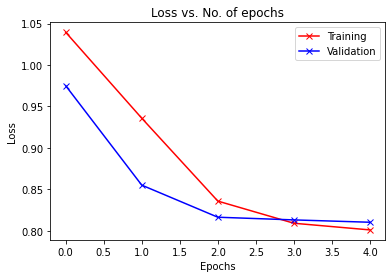

In [ ]:
plot_losses(history)

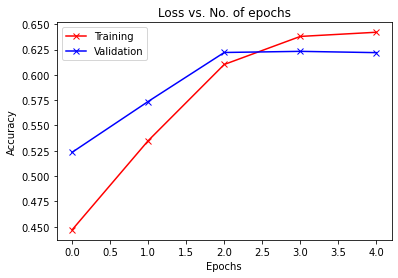

In [ ]:
plot_accuracy(history)

In [ ]:
# GETTING A CLASSIFICATION REPORT
from sklearn.metrics import classification_report

Y_pred_val = np.argmax(model.predict(X_val), axis=1)
class_report = classification_report(np.argmax(Y_val, axis=1),Y_pred_val)
print(class_report)

              precision    recall  f1-score   support

           0       0.63      0.60      0.61     12340
           1       0.51      0.50      0.51      6146
           2       0.66      0.69      0.68     14440

    accuracy                           0.62     32926
   macro avg       0.60      0.60      0.60     32926
weighted avg       0.62      0.62      0.62     32926



### Submitting on Kaggle

Run the cell below to generate the my_submission.csv file which you can upload for submission on Kaggle. 

The csv file can be located in the /content/Coronavirus-Tweets-Dataset-P2 folder. 

Please rename the file as \<id\>_\<name\>.csv before submitting.

In [ ]:
# DO NOT MODIFY
Y_pred = np.argmax(model.predict(X_test), axis=1)
submissions = pd.DataFrame({"UserName": list(range(1,len(Y_pred)+1)),
    "Sentiment": Y_pred})
submissions.to_csv("my_submission.csv", index=False, header=True)